In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

# List of prediction CSV files from each model (assuming 10 models for splits 0–9)
pred_files = [
    "/home/mezher/Documents/Deauville_DeepLearning/prediction/transfer/Run12/pred_split1_run12.csv",
    "/home/mezher/Documents/Deauville_DeepLearning/prediction/transfer/Run12/pred_split2_run12.csv",
    "/home/mezher/Documents/Deauville_DeepLearning/prediction/transfer/Run12/pred_split3_run12.csv",
    "/home/mezher/Documents/Deauville_DeepLearning/prediction/transfer/Run12/pred_split4_run12.csv",
    "/home/mezher/Documents/Deauville_DeepLearning/prediction/transfer/Run12/pred_split5_run12.csv",
    "/home/mezher/Documents/Deauville_DeepLearning/prediction/transfer/Run12/pred_split6_run12.csv",
    "/home/mezher/Documents/Deauville_DeepLearning/prediction/transfer/Run12/pred_split7_run12.csv",
    "/home/mezher/Documents/Deauville_DeepLearning/prediction/transfer/Run12/pred_split8_run12.csv",
    "/home/mezher/Documents/Deauville_DeepLearning/prediction/transfer/Run12/pred_split9_run12.csv"

    

]

# STEP 1: Within-model aggregation of MIP view predictions
# We'll create two lists: one for LARS-avg (mean) and one for LARS-max (max).
model_preds_avg = []  # per model aggregated predictions (LARS-avg)
model_preds_max = []  # per model aggregated predictions (LARS-max)

for file in pred_files:
    df = pd.read_csv(file)
    # Group by scan_id to aggregate the predictions for the individual MIP views.
    # We assume each file contains a 'scan_id', a 'probs' column, and optionally a 'target' column.
    df_avg = df.groupby('scan_id').agg({'probs': 'mean', 'target': 'first'}).reset_index()
    df_max = df.groupby('scan_id').agg({'probs': 'max', 'target': 'first'}).reset_index()
    model_preds_avg.append(df_avg)
    model_preds_max.append(df_max)

# STEP 2: Ensemble across models
# For each ensemble, we merge only the probability columns from the subsequent models,
# while retaining the 'target' from the first model.
ensemble_avg = model_preds_avg[0].rename(columns={'probs': 'probs_model0'})
for i, df_avg in enumerate(model_preds_avg[1:], start=1):
    df_avg = df_avg.rename(columns={'probs': f'probs_model{i}'})
    # Only merge the probability column, not the 'target'
    ensemble_avg = pd.merge(ensemble_avg, df_avg[['scan_id', f'probs_model{i}']], on='scan_id', how='outer')

ensemble_max = model_preds_max[0].rename(columns={'probs': 'probs_model0'})
for i, df_max in enumerate(model_preds_max[1:], start=1):
    df_max = df_max.rename(columns={'probs': f'probs_model{i}'})
    ensemble_max = pd.merge(ensemble_max, df_max[['scan_id', f'probs_model{i}']], on='scan_id', how='outer')

# Compute the final ensemble prediction per scan by averaging across models.
model_cols_avg = [col for col in ensemble_avg.columns if col.startswith('probs_model')]
ensemble_avg['ensemble_prob'] = ensemble_avg[model_cols_avg].mean(axis=1)

model_cols_max = [col for col in ensemble_max.columns if col.startswith('probs_model')]
ensemble_max['ensemble_prob'] = ensemble_max[model_cols_max].mean(axis=1)

# Use the 'target' column from ensemble_avg (assuming all models share the same ground truth).
auc_avg = roc_auc_score(ensemble_avg['target'], ensemble_avg['ensemble_prob'])
auc_max = roc_auc_score(ensemble_avg['target'], ensemble_max['ensemble_prob'])
print("Ensemble ROC AUC (LARS-avg):", auc_avg)
print("Ensemble ROC AUC (LARS-max):", auc_max)

# --- Calculate optimal threshold using Youden's index ---
# For LARS-avg:
fpr_avg, tpr_avg, thresholds_avg = roc_curve(ensemble_avg['target'], ensemble_avg['ensemble_prob'])
youden_index_avg = tpr_avg - fpr_avg
optimal_idx_avg = np.argmax(youden_index_avg)
optimal_threshold_avg = thresholds_avg[optimal_idx_avg]

# Compute predicted labels using the optimal threshold.
ensemble_avg['pred_label'] = (ensemble_avg['ensemble_prob'] >= optimal_threshold_avg).astype(int)
acc_avg_optimal = accuracy_score(ensemble_avg['target'], ensemble_avg['pred_label'])

# For LARS-max:
fpr_max, tpr_max, thresholds_max = roc_curve(ensemble_max['target'], ensemble_max['ensemble_prob'])
youden_index_max = tpr_max - fpr_max
optimal_idx_max = np.argmax(youden_index_max)
optimal_threshold_max = thresholds_max[optimal_idx_max]
ensemble_max['pred_label'] = (ensemble_max['ensemble_prob'] >= optimal_threshold_max).astype(int)
acc_max_optimal = accuracy_score(ensemble_max['target'], ensemble_max['pred_label'])

print("Optimal threshold for LARS-avg (Youden's index):", optimal_threshold_avg)
print("Optimal threshold for LARS-max (Youden's index):", optimal_threshold_max)
print("Ensemble Accuracy (LARS-avg) with optimal threshold:", acc_avg_optimal)
print("Ensemble Accuracy (LARS-max) with optimal thresshold:", acc_max_optimal)



# Save the final ensemble predictions to CSV files.
ensemble_avg.to_csv("/home/mezher/Documents/Deauville_DeepLearning/prediction/transfer/Run5/ensemble_avg.csv", index=False)
ensemble_max.to_csv("/home/mezher/Documents/Deauville_DeepLearning/prediction/transfer/Run5/ensemble_max.csv", index=False)


Ensemble ROC AUC (LARS-avg): 0.9410526315789474
Ensemble ROC AUC (LARS-max): 0.9417543859649122
Optimal threshold for LARS-avg (Youden's index): 0.14847939901388893
Optimal threshold for LARS-max (Youden's index): 0.2695524347777778
Ensemble Accuracy (LARS-avg) with optimal threshold: 0.8869565217391304
Ensemble Accuracy (LARS-max) with optimal thresshold: 0.8985507246376812



--- False Negatives Analysis (LARS-avg) ---
Number of false negatives: 8

--- False Negatives Analysis (LARS-max) ---
Number of false negatives: 8

Displaying up to 8 false negative scans (False Negative (LARS-avg))...


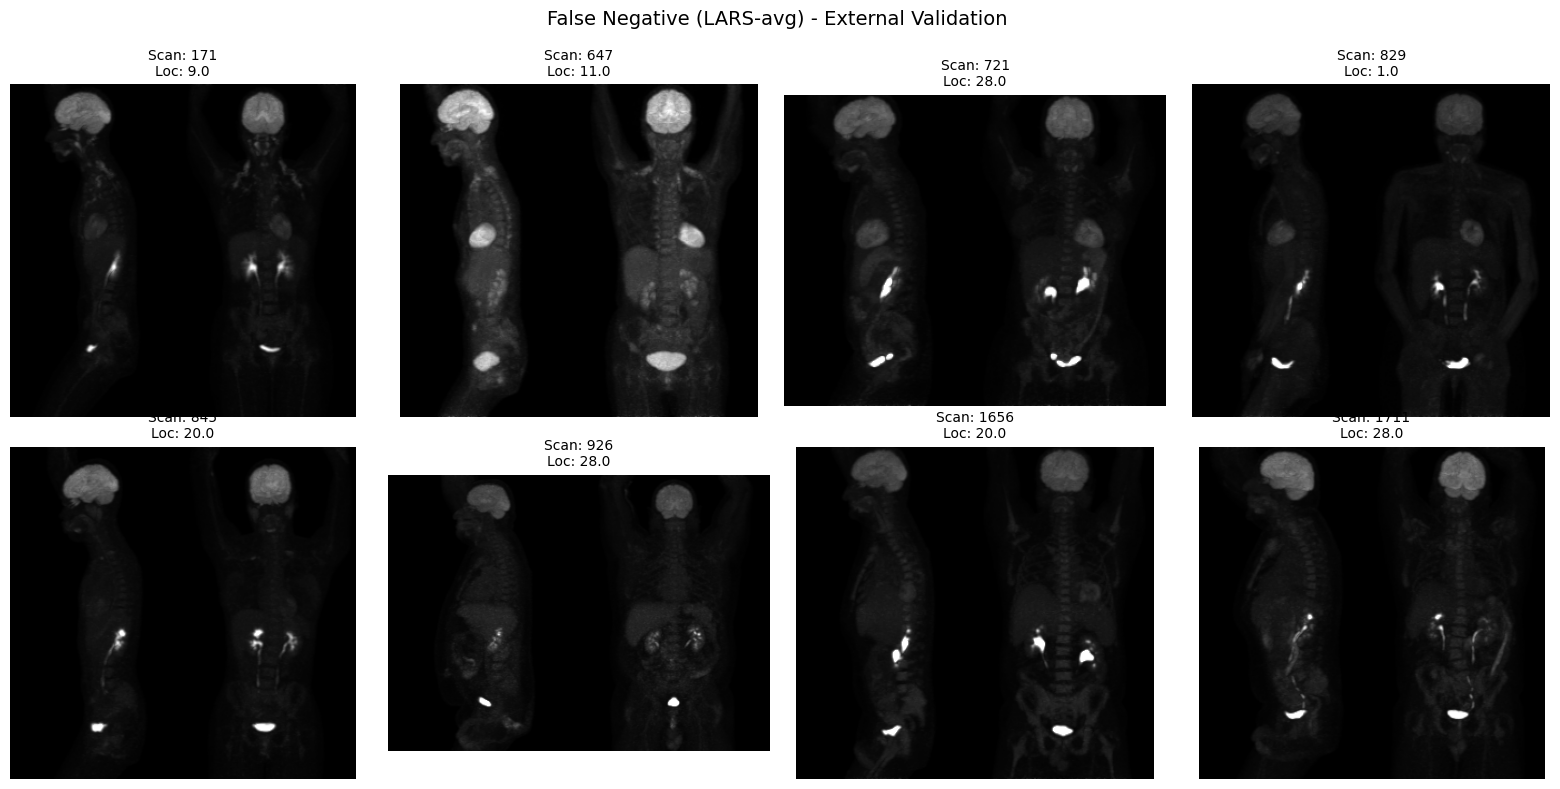


Displaying up to 8 false negative scans (False Negative (LARS-max))...


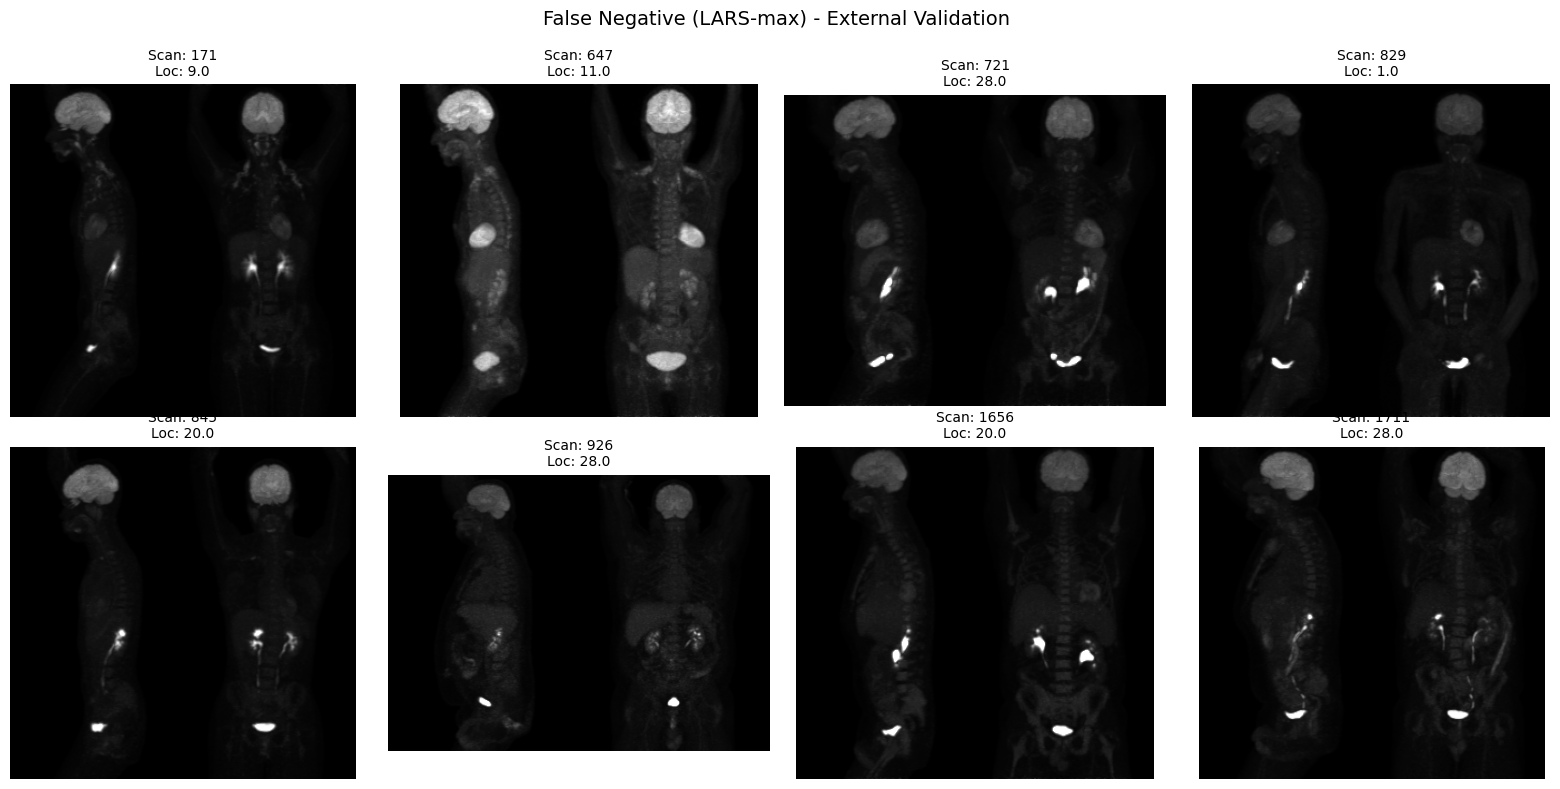

In [2]:
# Load metadata (e.g. original labels, lesion localizations)
meta_df = pd.read_csv("/home/mezher/Documents/Deauville_DeepLearning/splitting/data.csv")

# Fix column name and data type if necessary
meta_df.rename(columns=lambda x: x.strip(), inplace=True)
if 'target_loc' not in meta_df.columns and 'Lesion localisation' in meta_df.columns:
    meta_df.rename(columns={'Lesion localisation': 'target_loc'}, inplace=True)

# -------------------------------
# Function to report false negatives
# -------------------------------

def report_false_negatives(ensemble_df, method_name):
    print(f"\n--- False Negatives Analysis ({method_name}) ---")
    
    # Get FN rows: true label = 1, predicted label = 0
    false_negatives = ensemble_df[(ensemble_df['target'] == 1) & (ensemble_df['pred_label'] == 0)]
    
    print(f"Number of false negatives: {len(false_negatives)}")
    
    # Join with metadata to get localization
    merged = pd.merge(false_negatives[['scan_id']], meta_df[['scan_id', 'target_loc']], on='scan_id', how='left')

    return merged

# -------------------------------
# Analyze false negatives
# -------------------------------

fn_avg_info = report_false_negatives(ensemble_avg, "LARS-avg")
fn_max_info = report_false_negatives(ensemble_max, "LARS-max")

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

def show_false_negative_images_unique(fn_df, meta_df, title_prefix, base_path,
                                      norm=True, max_scans=12, n_cols=4):
    """
    Displays false negative images in a grid layout, ensuring each scan_id is processed only once.
    
    For each unique scan_id in fn_df, the function:
      - Looks up the sagittal and coronal filenames in meta_df (from the "filename" column).
      - Loads and normalizes the images from base_path (files assumed to be stored here).
      - Stacks them horizontally into a composite image.
      - Adds a title including the scan ID and the lesion localization.
    The composite images are then arranged in a grid with n_cols columns.
    
    Parameters:
      fn_df: DataFrame containing at least a 'scan_id' column for false negatives.
      meta_df: DataFrame from data.csv with columns ['scan_id', 'filename', 'target_loc'].
      title_prefix: A prefix for the overall title (e.g., "False Negative (LARS-avg External Validation)").
      base_path: Directory where the image .npy files are stored.
      norm: If True, clips pixel values to [0, 30] and rescales them to [0, 1].
      max_scans: Maximum number of false negative scans to display.
      n_cols: Number of columns in the grid.
    """
    # Get unique scan IDs so each is processed only once
    unique_scan_ids = fn_df['scan_id'].drop_duplicates().head(max_scans)
    print(f"\nDisplaying up to {len(unique_scan_ids)} false negative scans ({title_prefix})...")

    composite_images = []
    titles = []
    
    for scan_id in unique_scan_ids:
        # Filter meta_df for the current scan_id
        df_scan = meta_df[meta_df['scan_id'] == scan_id]
        
        # Look for filenames containing '_sag' and '_cor'
        sag_rows = df_scan[df_scan['filename'].str.contains('_sag')]
        cor_rows = df_scan[df_scan['filename'].str.contains('_cor')]
        
        if sag_rows.empty or cor_rows.empty:
            print(f"Skipping scan_id {scan_id}: missing either sagittal or coronal image.")
            continue
        
        # Grab the first row for each view
        sag_filename = sag_rows.iloc[0]['filename']
        cor_filename = cor_rows.iloc[0]['filename']
        target_loc = df_scan.iloc[0]['target_loc']
        
        # Build full paths for images
        sag_path = os.path.join(base_path, sag_filename)
        cor_path = os.path.join(base_path, cor_filename)
        
        try:
            sag_img = np.load(sag_path)
            cor_img = np.load(cor_path)
            
            # Normalize if requested
            if norm:
                sag_img = np.clip(sag_img, 0, 30)
                sag_img = (sag_img - sag_img.min()) / (sag_img.max() - sag_img.min() + 1e-6)
                cor_img = np.clip(cor_img, 0, 30)
                cor_img = (cor_img - cor_img.min()) / (cor_img.max() - cor_img.min() + 1e-6)
            
            # Stack the sagittal and coronal MIPs horizontally
            composite = np.hstack((sag_img, cor_img))
            composite_images.append(composite)
            
            # Title includes scan ID and localization
            titles.append(f"Scan: {scan_id}\nLoc: {target_loc}")
        except Exception as e:
            print(f"Error loading images for scan_id {scan_id}: {e}")

    # If no composite images were created, just return
    if not composite_images:
        print("No composite images to display.")
        return

    # Plot them in a grid
    n_images = len(composite_images)
    n_rows = math.ceil(n_images / n_cols)
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axs = np.atleast_1d(axs).flatten()
    
    for i in range(n_rows * n_cols):
        ax = axs[i]
        if i < n_images:
            ax.imshow(composite_images[i], cmap='gray')
            ax.set_title(titles[i], fontsize=10)
        ax.axis('off')
    
    plt.suptitle(f"{title_prefix} - External Validation", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


# Example usage:
show_false_negative_images_unique(fn_avg_info, meta_df, "False Negative (LARS-avg)",
    base_path="/home/mezher/Documents/Deauville_DeepLearning/splitting",
    norm=True, max_scans=20, n_cols=4)

show_false_negative_images_unique(fn_max_info, meta_df, "False Negative (LARS-max)",
    base_path="/home/mezher/Documents/Deauville_DeepLearning/splitting",
    norm=True, max_scans=20, n_cols=4)




--- False Positives Analysis (LARS-avg) ---
Number of false positives: 31

--- False Positives Analysis (LARS-max) ---
Number of false positives: 27

Displaying up to 20 false positive scans (False Positive (LARS-avg))...


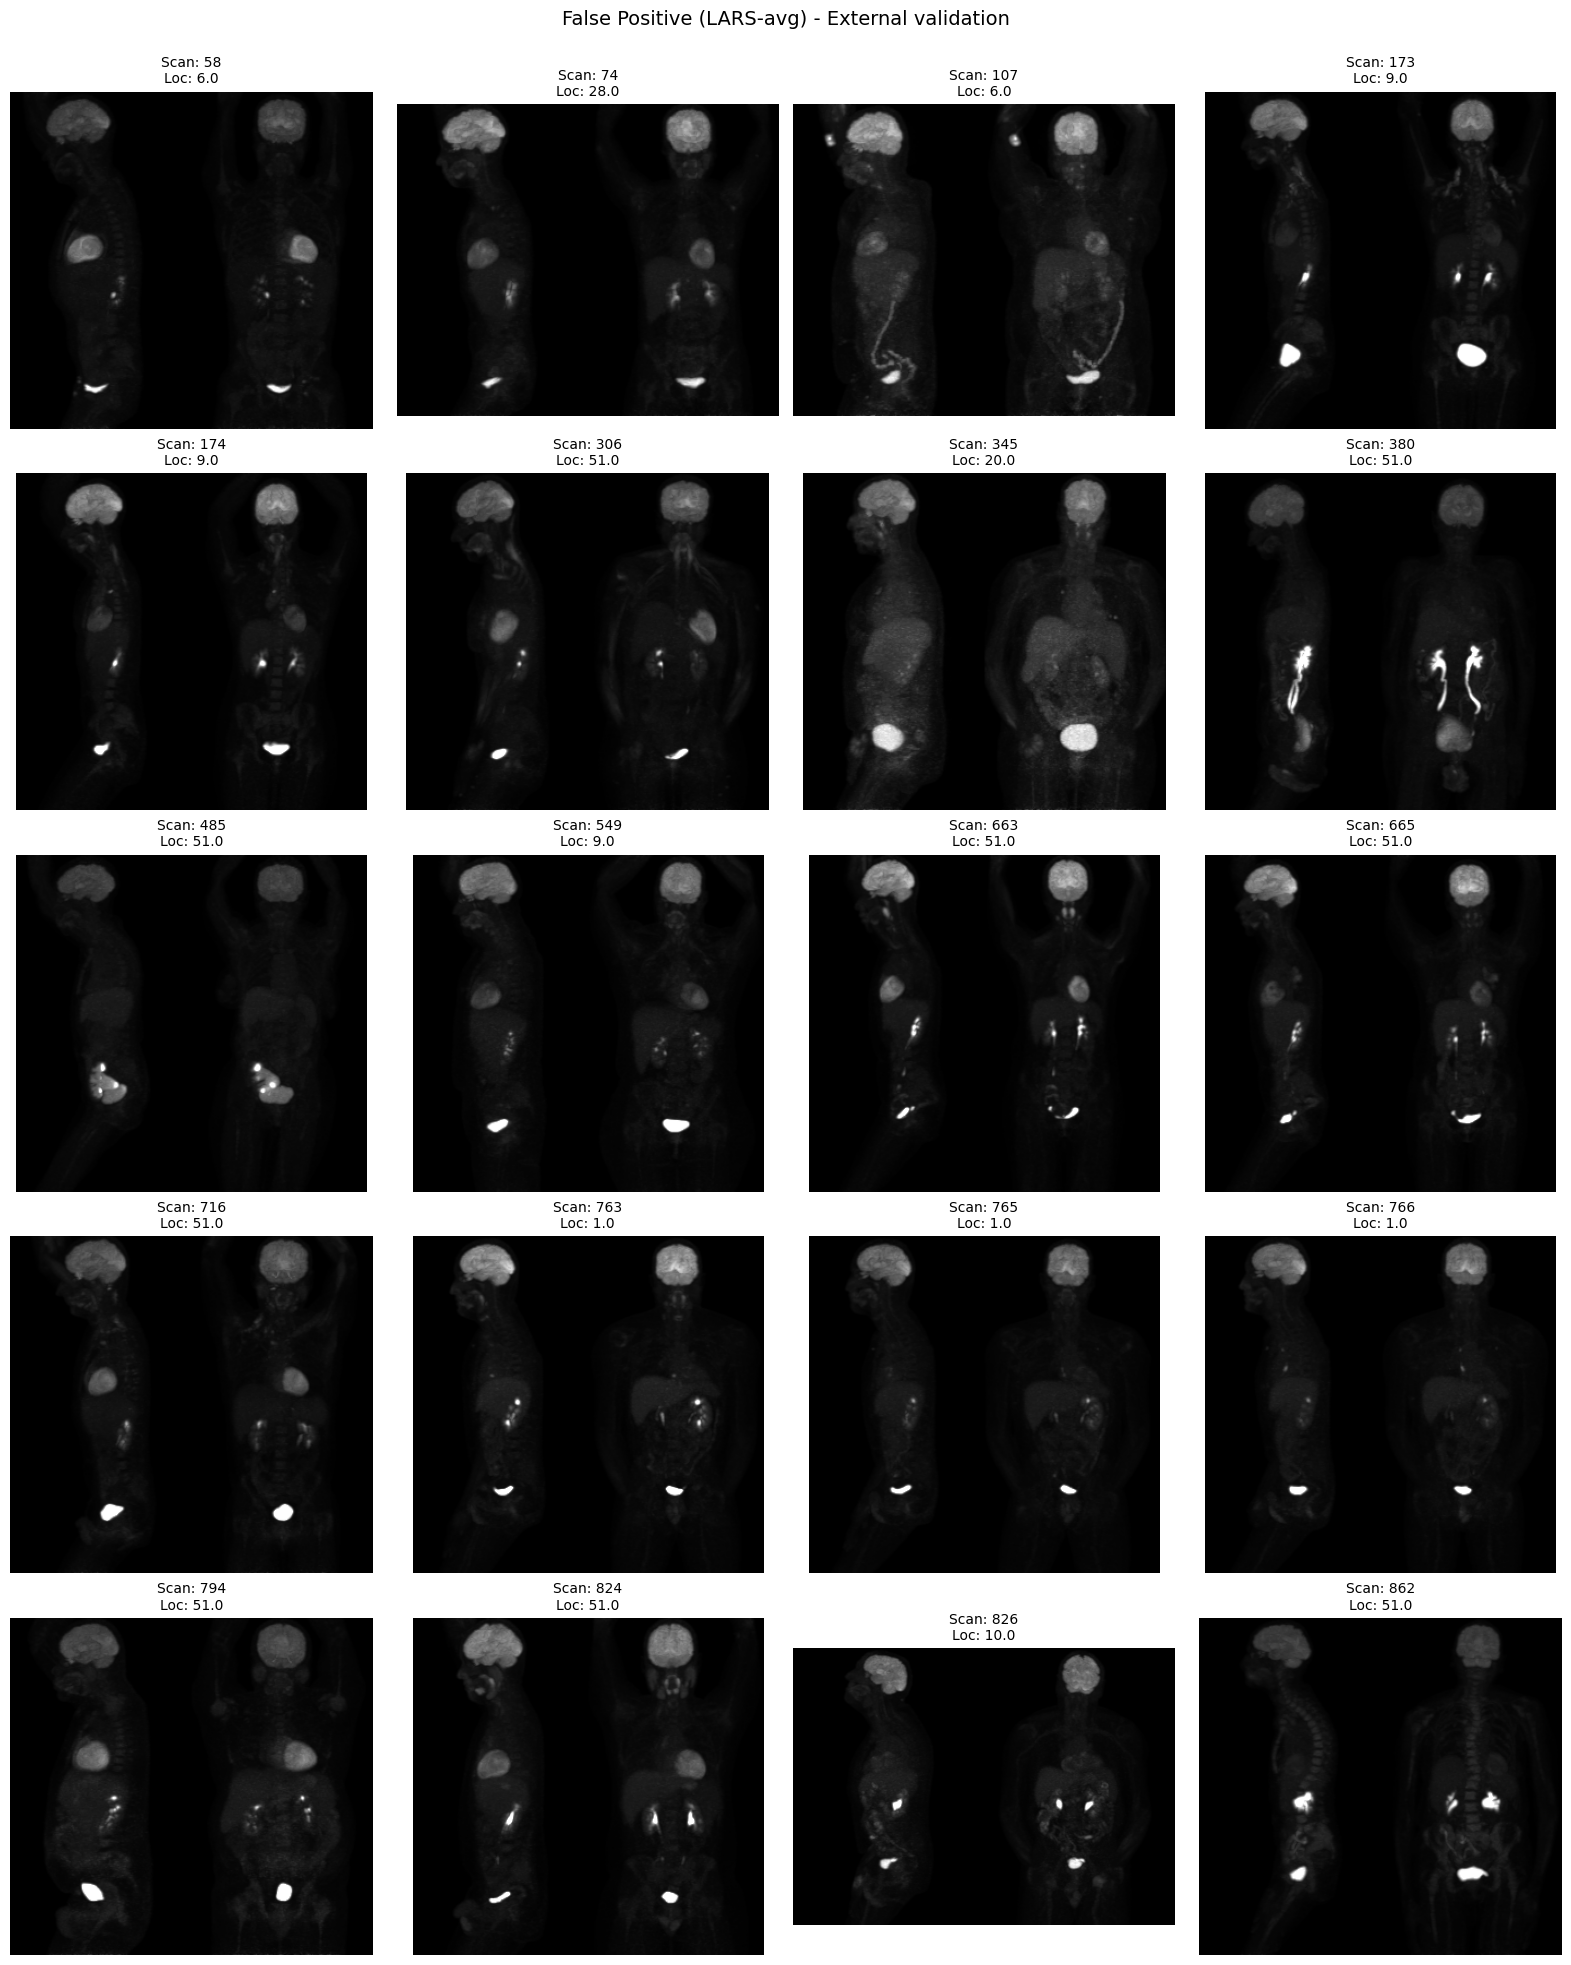


Displaying up to 20 false positive scans (False Positive (LARS-max))...


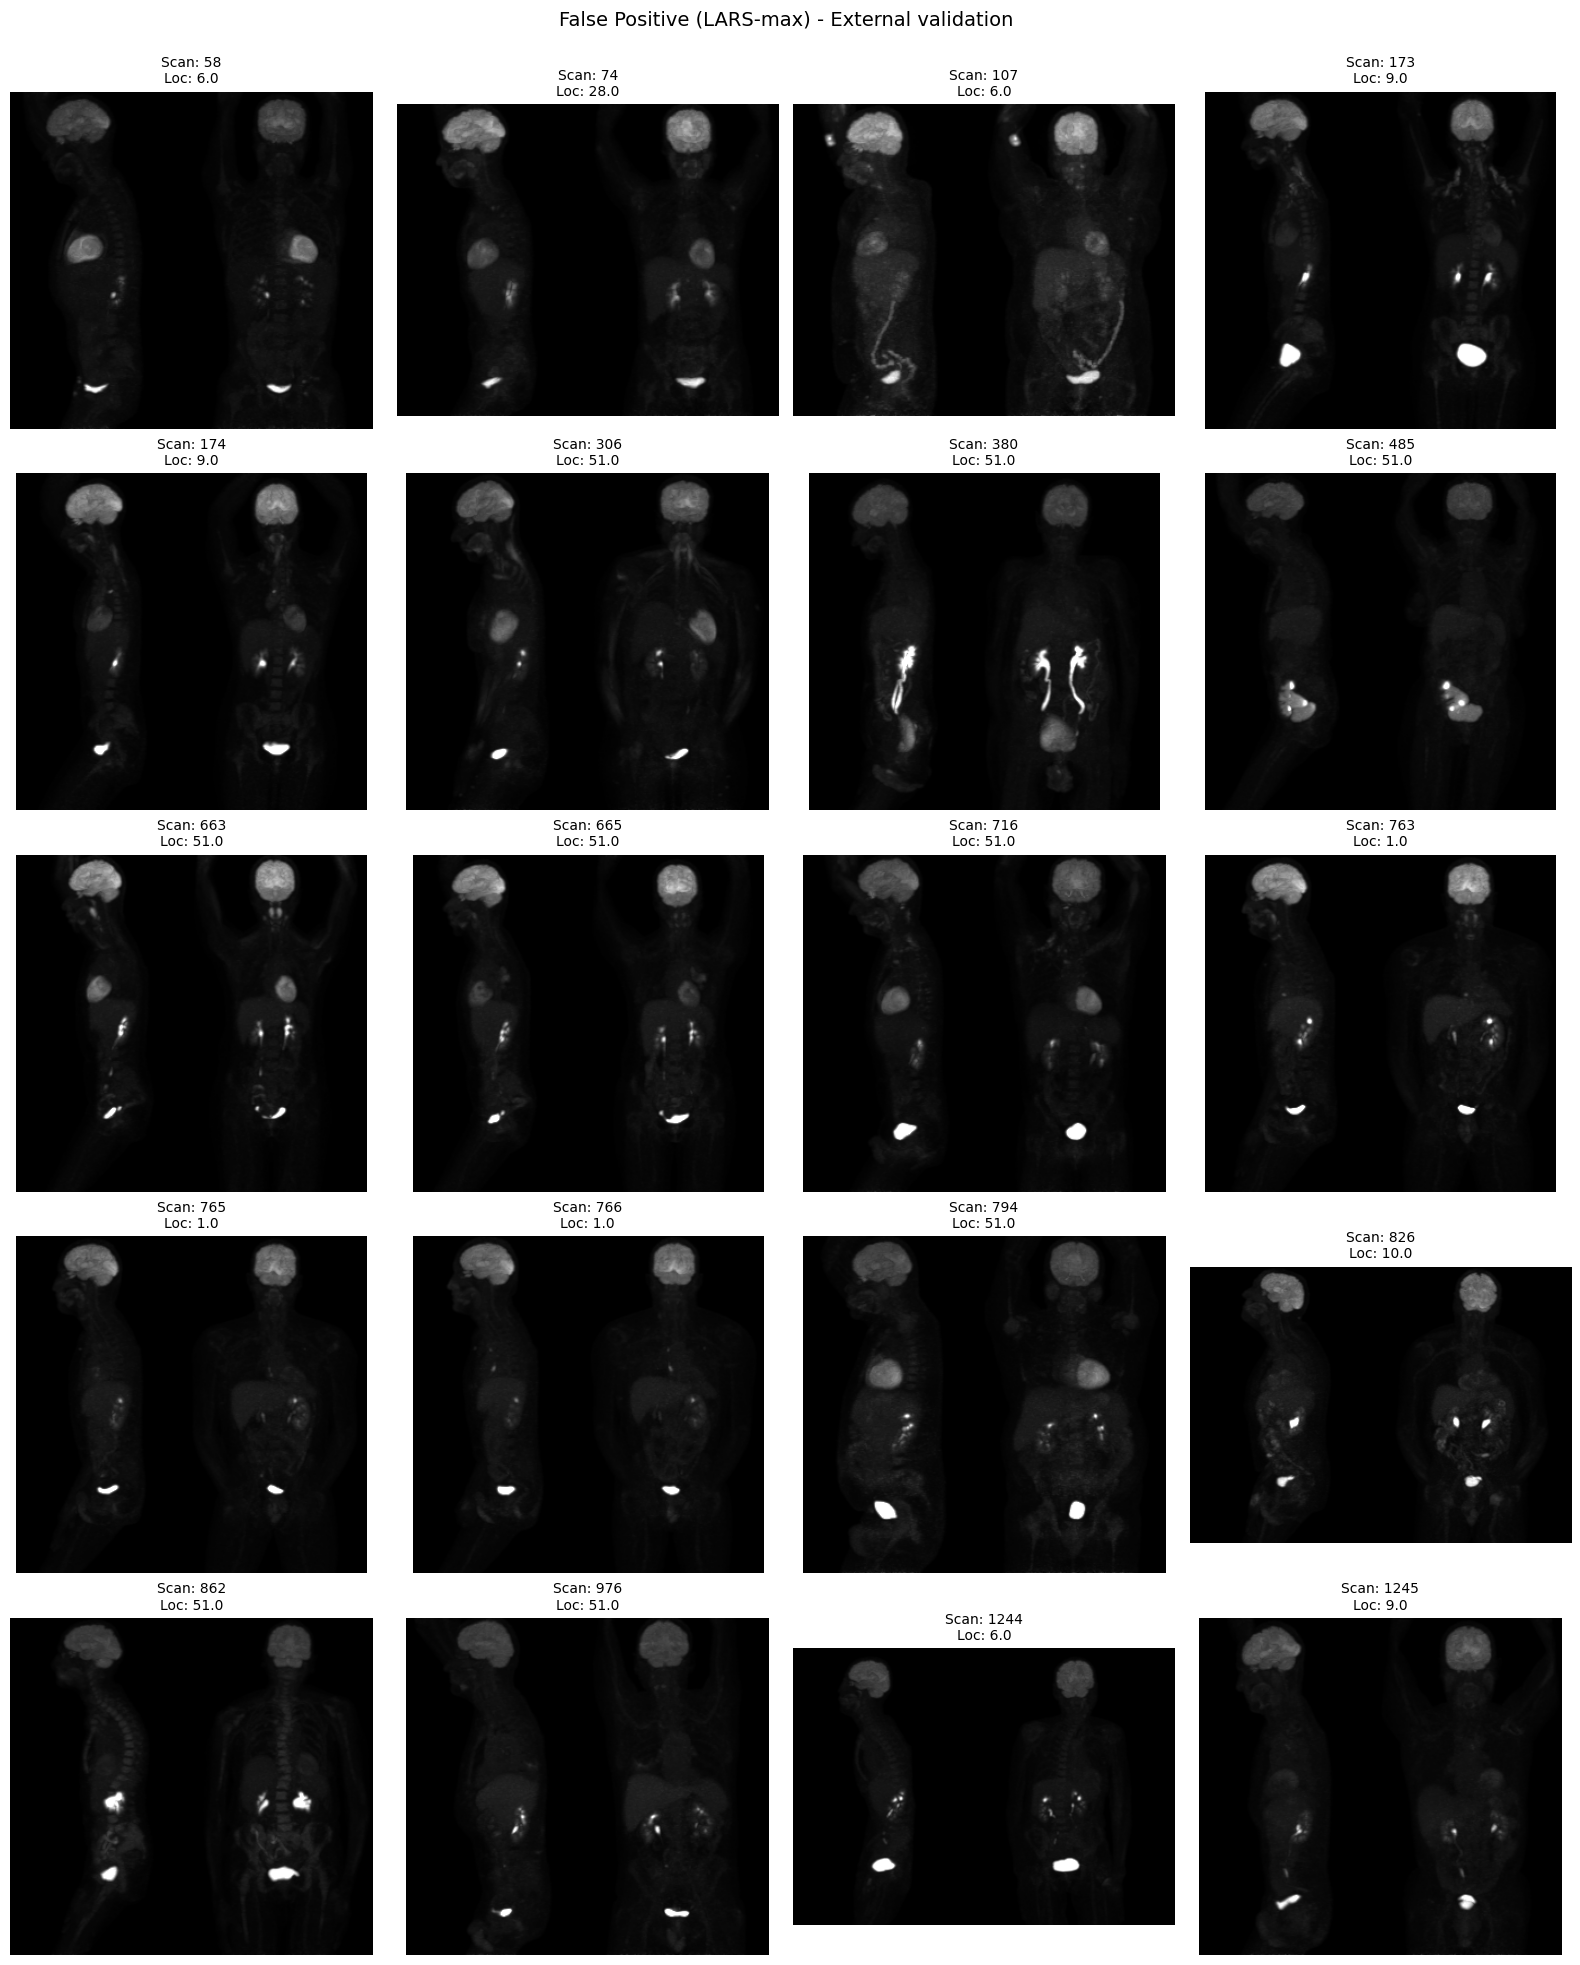

In [3]:
# -------------------------------
# Function to report false positives
# -------------------------------

def report_false_positives(ensemble_df, method_name):
    print(f"\n--- False Positives Analysis ({method_name}) ---")
    
    # Get FP rows: true label = 0, predicted label = 1
    false_positives = ensemble_df[(ensemble_df['target'] == 0) & (ensemble_df['pred_label'] == 1)]
    
    print(f"Number of false positives: {len(false_positives)}")
    
    # Join with metadata to get lesion localization or other relevant info
    merged = pd.merge(false_positives[['scan_id']], meta_df[['scan_id', 'target_loc']], on='scan_id', how='left')
    return merged

# -------------------------------
# Function to display false positive images in a grid
# (mirroring the false negative visualization)
# -------------------------------

def show_false_positive_images_unique(fp_df, meta_df, title_prefix, base_path,
                                        norm=True, max_scans=12, n_cols=4):
    """
    Displays false positive images in a grid layout, ensuring each scan_id is processed only once.
    
    For each unique scan_id in fp_df, the function:
      - Looks up the sagittal and coronal filenames in meta_df (from the "filename" column).
      - Loads and normalizes the images from base_path.
      - Stacks them horizontally into a composite image.
      - Adds a title including the scan ID and the lesion localization.
    The composite images are then arranged in a grid with n_cols columns.
    
    Parameters:
      fp_df: DataFrame containing at least a 'scan_id' column for false positives.
      meta_df: DataFrame from data.csv with columns ['scan_id', 'filename', 'target_loc'].
      title_prefix: A prefix for the overall title (e.g., "False Positive (LARS-avg External Validation)").
      base_path: Directory where the image .npy files are stored.
      norm: If True, clips pixel values to [0, 30] and rescales them to [0, 1].
      max_scans: Maximum number of false positive scans to display.
      n_cols: Number of columns in the grid.
    """
    # Get unique scan IDs so each is processed only once
    unique_scan_ids = fp_df['scan_id'].drop_duplicates().head(max_scans)
    print(f"\nDisplaying up to {len(unique_scan_ids)} false positive scans ({title_prefix})...")
    
    composite_images = []
    titles = []
    
    for scan_id in unique_scan_ids:
        # Filter meta_df for the current scan_id
        df_scan = meta_df[meta_df['scan_id'] == scan_id]
        
        # Look for filenames containing '_sag' and '_cor'
        sag_rows = df_scan[df_scan['filename'].str.contains('_sag')]
        cor_rows = df_scan[df_scan['filename'].str.contains('_cor')]
        
        if sag_rows.empty or cor_rows.empty:
            print(f"Skipping scan_id {scan_id}: missing either sagittal or coronal image.")
            continue
        
        # Grab the first row for each view
        sag_filename = sag_rows.iloc[0]['filename']
        cor_filename = cor_rows.iloc[0]['filename']
        target_loc = df_scan.iloc[0]['target_loc']
        
        # Build full paths
        sag_path = os.path.join(base_path, sag_filename)
        cor_path = os.path.join(base_path, cor_filename)
        
        try:
            sag_img = np.load(sag_path)
            cor_img = np.load(cor_path)
            
            # Normalize if requested
            if norm:
                sag_img = np.clip(sag_img, 0, 30)
                sag_img = (sag_img - sag_img.min()) / (sag_img.max() - sag_img.min() + 1e-6)
                cor_img = np.clip(cor_img, 0, 30)
                cor_img = (cor_img - cor_img.min()) / (cor_img.max() - cor_img.min() + 1e-6)
            
            # Stack the sagittal and coronal MIPs horizontally
            composite = np.hstack((sag_img, cor_img))
            composite_images.append(composite)
            
            # Title includes only scan ID and localization
            titles.append(f"Scan: {scan_id}\nLoc: {target_loc}")
        except Exception as e:
            print(f"Error loading images for scan_id {scan_id}: {e}")
    
    # If no composite images were created, just return
    if not composite_images:
        print("No composite images to display.")
        return
    
    # Calculate grid size
    n_images = len(composite_images)
    n_rows = math.ceil(n_images / n_cols)
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axs = np.atleast_1d(axs).flatten()
    
    for i in range(n_rows * n_cols):
        ax = axs[i]
        if i < n_images:
            ax.imshow(composite_images[i], cmap='gray')
            ax.set_title(titles[i], fontsize=10)
        ax.axis('off')
    
    plt.suptitle(f"{title_prefix} - External validation", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# Example usage:
# Assuming you already have your ensemble results (with a column 'pred_label' representing 0/1 predictions)
fp_avg_info = report_false_positives(ensemble_avg, "LARS-avg")
fp_max_info = report_false_positives(ensemble_max, "LARS-max")

show_false_positive_images_unique(fp_avg_info, meta_df, "False Positive (LARS-avg)",
    base_path="/home/mezher/Documents/Deauville_DeepLearning/splitting",
    norm=True, max_scans=20, n_cols=4)

show_false_positive_images_unique(fp_max_info, meta_df, "False Positive (LARS-max)",
    base_path="/home/mezher/Documents/Deauville_DeepLearning/splitting",
    norm=True, max_scans=20, n_cols=4)


Detailed Classification Report (LARS-avg External Validation):
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       285
           1       0.63      0.87      0.73        60

    accuracy                           0.89       345
   macro avg       0.80      0.88      0.83       345
weighted avg       0.91      0.89      0.89       345


Detailed Classification Report (LARS-max External Validation):
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       285
           1       0.66      0.87      0.75        60

    accuracy                           0.90       345
   macro avg       0.81      0.89      0.84       345
weighted avg       0.92      0.90      0.90       345



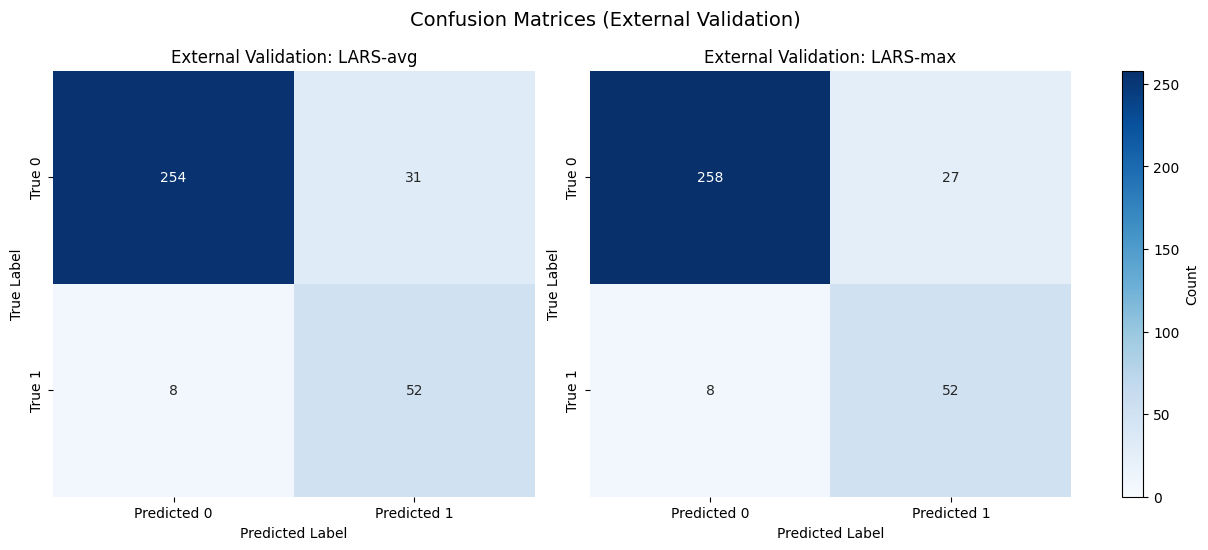


LARS-avg External Validation: False Positives: 31, False Negatives: 8
LARS-max External Validation: False Positives: 27, False Negatives: 8


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assume ensemble_avg and ensemble_max DataFrames are already available
# and they contain at least the following columns: 'target', 'pred_label', and 'scan_id'

# Compute confusion matrices for both variants
cm_avg = confusion_matrix(ensemble_avg['target'], ensemble_avg['pred_label'])
cm_max = confusion_matrix(ensemble_max['target'], ensemble_max['pred_label'])

# Print detailed classification reports for both
print("Detailed Classification Report (LARS-avg External Validation):")
print(classification_report(ensemble_avg['target'], ensemble_avg['pred_label']))
print("\nDetailed Classification Report (LARS-max External Validation):")
print(classification_report(ensemble_max['target'], ensemble_max['pred_label']))

# Determine the maximum value across both confusion matrices for shared scaling
max_val = max(cm_avg.max(), cm_max.max())

# 3) Determine the maximum value across both confusion matrices for a shared scale
max_val = max(cm_avg.max(), cm_max.max())

# 4) Create side-by-side subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# We'll first plot each heatmap with cbar=False so we can add a single color bar after.
im0 = sns.heatmap(cm_avg, annot=True, fmt="d", cmap="Blues", cbar=False,
                  vmin=0, vmax=max_val, ax=axs[0],
                  xticklabels=["Predicted 0", "Predicted 1"],
                  yticklabels=["True 0", "True 1"])
axs[0].set_title("External Validation: LARS-avg")
axs[0].set_xlabel("Predicted Label")
axs[0].set_ylabel("True Label")

im1 = sns.heatmap(cm_max, annot=True, fmt="d", cmap="Blues", cbar=False,
                  vmin=0, vmax=max_val, ax=axs[1],
                  xticklabels=["Predicted 0", "Predicted 1"],
                  yticklabels=["True 0", "True 1"])
axs[1].set_title("External Validation: LARS-max")
axs[1].set_xlabel("Predicted Label")
axs[1].set_ylabel("True Label")

# 5) Add one common color bar using the first heatmap's “collections”
cbar = fig.colorbar(im0.collections[0], ax=axs, shrink=1, label='Count')


plt.suptitle("Confusion Matrices (External Validation)", fontsize=14, y=1.07)
plt.show()
plt.show()

# Report false positives and false negatives for each variant
fp_avg = ensemble_avg[(ensemble_avg['target'] == 0) & (ensemble_avg['pred_label'] == 1)]
fn_avg = ensemble_avg[(ensemble_avg['target'] == 1) & (ensemble_avg['pred_label'] == 0)]
fp_max = ensemble_max[(ensemble_max['target'] == 0) & (ensemble_max['pred_label'] == 1)]
fn_max = ensemble_max[(ensemble_max['target'] == 1) & (ensemble_max['pred_label'] == 0)]

print(f"\nLARS-avg External Validation: False Positives: {len(fp_avg)}, False Negatives: {len(fn_avg)}")
print(f"LARS-max External Validation: False Positives: {len(fp_max)}, False Negatives: {len(fn_max)}")


/tmp/ipykernel_1708753/380044731.py:54: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


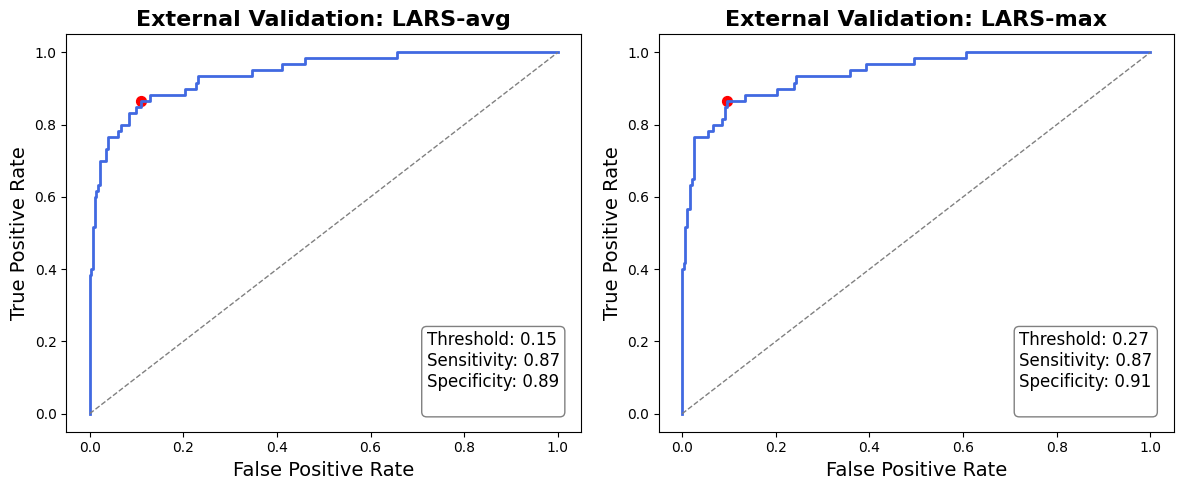

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

# --- Calculate ROC curve for LARS-avg Ensemble (External Validation) ---
fpr_avg, tpr_avg, thresholds_avg = roc_curve(ensemble_avg['target'], ensemble_avg['ensemble_prob'])
roc_auc_avg = roc_auc_score(ensemble_avg['target'], ensemble_avg['ensemble_prob'])
optimal_idx_avg = np.argmax(tpr_avg - fpr_avg)
optimal_threshold_avg = thresholds_avg[optimal_idx_avg]
sensitivity_avg = tpr_avg[optimal_idx_avg]
specificity_avg = 1 - fpr_avg[optimal_idx_avg]
false_positive_rate_avg = fpr_avg[optimal_idx_avg]

# --- Calculate ROC curve for LARS-max Ensemble (External Validation) ---
fpr_max, tpr_max, thresholds_max = roc_curve(ensemble_max['target'], ensemble_max['ensemble_prob'])
roc_auc_max = roc_auc_score(ensemble_max['target'], ensemble_max['ensemble_prob'])
optimal_idx_max = np.argmax(tpr_max - fpr_max)
optimal_threshold_max = thresholds_max[optimal_idx_max]
sensitivity_max = tpr_max[optimal_idx_max]
specificity_max = 1 - fpr_max[optimal_idx_max]
false_positive_rate_max = fpr_max[optimal_idx_max]


# Create two subplots for LARS-avg and LARS-max external validation ROC curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# --- Plot for LARS-avg ---
ax1.plot(fpr_avg, tpr_avg, lw=2, color='royalblue', label=f'AUC = {roc_auc_avg:.3f}')
ax1.plot([0, 1], [0, 1], lw=1, linestyle='--', color='gray')
ax1.scatter(fpr_avg[optimal_idx_avg], tpr_avg[optimal_idx_avg], color='red', s=50)
ax1.set_title("External Validation: LARS-avg", fontsize=16, fontweight='bold')
ax1.set_xlabel("False Positive Rate", fontsize=14)
ax1.set_ylabel("True Positive Rate", fontsize=14)
# Annotate with threshold, sensitivity, specificity and FPR
annotation_avg = (f"Threshold: {optimal_threshold_avg:.2f}\n"
                  f"Sensitivity: {sensitivity_avg:.2f}\n"
                  f"Specificity: {specificity_avg:.2f}\n")
ax1.text(0.70, 0.05, annotation_avg, transform=ax1.transAxes, fontsize=12,
         verticalalignment='bottom', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1))

# --- Plot for LARS-max ---
ax2.plot(fpr_max, tpr_max, lw=2, color='royalblue', label=f'AUC = {roc_auc_max:.3f}')
ax2.plot([0, 1], [0, 1], lw=1, linestyle='--', color='gray')
ax2.scatter(fpr_max[optimal_idx_max], tpr_max[optimal_idx_max], color='red', s=50)
ax2.set_title("External Validation: LARS-max", fontsize=16, fontweight='bold')
ax2.set_xlabel("False Positive Rate", fontsize=14)
ax2.set_ylabel("True Positive Rate", fontsize=14)
annotation_max = (f"Threshold: {optimal_threshold_max:.2f}\n"
                  f"Sensitivity: {sensitivity_max:.2f}\n"
                  f"Specificity: {specificity_max:.2f}\n")
ax2.text(0.70, 0.05, annotation_max, transform=ax2.transAxes, fontsize=12,
         verticalalignment='bottom', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1))

plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    roc_auc_score, accuracy_score, confusion_matrix,
    roc_curve
)

# 1. The function to get bootstrap-based confidence intervals
def bootstrap_metric(y_true, y_pred, metric_func, n_boot=1000, random_state=42):
    """
    Bootstraps a metric (e.g. accuracy, AUC) and returns the median + 95% CI.

    Parameters:
      y_true (1D array): ground truth labels, size N
      y_pred (1D array): predictions (labels or probabilities), size N
      metric_func (callable): function f(y_true, y_pred) -> scalar metric
      n_boot (int): number of bootstrap replicates
      random_state (int): for reproducibility

    Returns:
      (median_metric, (ci_lower, ci_upper))
    """
    rng = np.random.RandomState(random_state)
    n = len(y_true)
    metrics = []

    for _ in range(n_boot):
        # Sample indices with replacement
        indices = rng.randint(0, n, n)
        # Compute the metric on resampled subset
        m = metric_func(y_true[indices], y_pred[indices])
        metrics.append(m)

    metrics = np.array(metrics)
    ci_lower = np.percentile(metrics, 2.5)
    ci_upper = np.percentile(metrics, 97.5)
    median_val = np.median(metrics)
    return median_val, (ci_lower, ci_upper)


# 2. Load or generate ensemble DataFrames (as you do in your code).
#    Suppose you have already run your code to create:
#       ensemble_avg  and  ensemble_max
#    each with columns: ['scan_id','target','ensemble_prob','pred_label', ...]
#    We'll do the same threshold logic as you:

# (Below is an example snippet that might be near the end of your script,
#  after you compute ensemble_avg and ensemble_max with final predictions.)

# 3. Use the bootstrap function for each metric we care about
#    For LARS-avg:
y_true_avg  = ensemble_avg['target'].values
prob_avg    = ensemble_avg['ensemble_prob'].values
pred_label_avg = ensemble_avg['pred_label'].values

# 3a) AUC with bootstrapping
auc_median_avg, (auc_lower_avg, auc_upper_avg) = bootstrap_metric(
    y_true_avg, prob_avg, roc_auc_score, n_boot=1000
)
print(f"[LARS-avg] AUC: {auc_median_avg:.3f} (95% CI: {auc_lower_avg:.3f}-{auc_upper_avg:.3f})")

# 3b) Accuracy with bootstrapping
acc_median_avg, (acc_lower_avg, acc_upper_avg) = bootstrap_metric(
    y_true_avg, pred_label_avg, accuracy_score, n_boot=1000
)
print(f"[LARS-avg] Accuracy: {acc_median_avg:.3f} (95% CI: {acc_lower_avg:.3f}-{acc_upper_avg:.3f})")

# 3c) If you also want sensitivity, specificity, define a function:
def sensitivity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fn) if (tp + fn) > 0 else np.nan

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else np.nan

sens_median_avg, (sens_low_avg, sens_high_avg) = bootstrap_metric(
    y_true_avg, pred_label_avg, sensitivity_score
)
spec_median_avg, (spec_low_avg, spec_high_avg) = bootstrap_metric(
    y_true_avg, pred_label_avg, specificity_score
)
print(f"[LARS-avg] Sensitivity: {sens_median_avg:.3f} 95%CI [{sens_low_avg:.3f}-{sens_high_avg:.3f}]")
print(f"[LARS-avg] Specificity: {spec_median_avg:.3f} 95%CI [{spec_low_avg:.3f}-{spec_high_avg:.3f}]")


# 4. Do exactly the same for LARS-max:
y_true_max  = ensemble_max['target'].values
prob_max    = ensemble_max['ensemble_prob'].values
pred_label_max = ensemble_max['pred_label'].values

# 4a) AUC with bootstrapping
auc_median_max, (auc_lower_max, auc_upper_max) = bootstrap_metric(
    y_true_max, prob_max, roc_auc_score, n_boot=1000
)
print(f"[LARS-max] AUC: {auc_median_max:.3f} (95% CI: {auc_lower_max:.3f}-{auc_upper_max:.3f})")

# 4b) Accuracy with bootstrapping
acc_median_max, (acc_lower_max, acc_upper_max) = bootstrap_metric(
    y_true_max, pred_label_max, accuracy_score, n_boot=1000
)
print(f"[LARS-max] Accuracy: {acc_median_max:.3f} (95% CI: {acc_lower_max:.3f}-{acc_upper_max:.3f})")

# 4c) Sensitivity / Specificity for LARS-max
sens_median_max, (sens_low_max, sens_high_max) = bootstrap_metric(
    y_true_max, pred_label_max, sensitivity_score
)
spec_median_max, (spec_low_max, spec_high_max) = bootstrap_metric(
    y_true_max, pred_label_max, specificity_score
)
print(f"[LARS-max] Sensitivity: {sens_median_max:.3f} 95%CI [{sens_low_max:.3f}-{sens_high_max:.3f}]")
print(f"[LARS-max] Specificity: {spec_median_max:.3f} 95%CI [{spec_low_max:.3f}-{spec_high_max:.3f}]")


[LARS-avg] AUC: 0.942 (95% CI: 0.905-0.974)
[LARS-avg] Accuracy: 0.887 (95% CI: 0.852-0.922)
[LARS-avg] Sensitivity: 0.868 95%CI [0.780-0.954]
[LARS-avg] Specificity: 0.892 95%CI [0.849-0.926]
[LARS-max] AUC: 0.943 (95% CI: 0.906-0.974)
[LARS-max] Accuracy: 0.899 (95% CI: 0.864-0.930)
[LARS-max] Sensitivity: 0.868 95%CI [0.780-0.954]
[LARS-max] Specificity: 0.906 95%CI [0.869-0.939]
